<a href="https://colab.research.google.com/github/ImranNust/DeepLearningWithPyTorch/blob/main/Module2_DistinguishingBirdsFromAirplanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<h1> <center> <b> <u> Distinguishing Birds from Airplanes </u> </b> </center> </h1>

The first step involves building the dataset. We’ll pick out all the birds and airplanes from our CIFAR-10 dataset and build a neural network that can tell birds and airplanes apart.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '/content/'
cifar10 = datasets.CIFAR10(
    data_path, train = True, download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content/


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train = False, download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


---

<h2> <center> <b> <u> Building the Dataset </u> </b> </center> </h2>

The first step is to get the data in the right shape. We could create a `Dataset` subclass that only includes birds and airplanes. However, the dataset is small, and we only need indexing and `len` to work on our dataset. It doesn’t actually have to be a subclass of `torch.utils.data.dataset.Dataset`! Well, why not take a shortcut and just filter the data in `cifar10` and remap the labels so they are contiguous? Here’s how:


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]

cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

The cifar2 object satisfies the basic requirements for a Dataset—that is,`__len__` and `__getitem__` are defined — so we’re going to use that. We should be aware, however, that this is a clever shortcut and we might wish to implement a proper `Dataset` if we hit limitations with it.

We have a dataset! Next, we need a `model` to feed our data to.

---

<h3> <center> <b> <u> A Fully Connected Model </u> </b> </center> </h3>

Our image size is  $32 × 32 × 3$: that is, 3,072 input features per sample. Our new model would be an `nn.Linear` with $3,072$ input features and some number of hidden features, followed by an activation, and then another `nn.Linear` that tapers the network down to an appropriate output number of features (2, for this use case)

![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic77.png)

In [6]:
import torch.nn as nn
n_out = 2
model = nn.Sequential(
    nn.Linear( 3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
    )

So we have a model. Next we’ll discuss what our model output should be.

---
<h3> <center> <b> <u> Representing the output as probabilities </u> </b> </center> </h3>

Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values represent probabilities. The expression for softmax is shown in the below figure.

![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic78.png)

That is, we take the elements of the vector, compute the elementwise exponential,
and divide each element by the sum of exponentials. In code, it’s something like this:

In [7]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

# Let's test it on an input vector
x = torch.tensor([1.0, 2.0, 3.0])

print('Input: {}'.format(x))
print('Softmax Output: {}'.format(softmax(x)))

# As expected, it satisfies the constraints on probability:
print(softmax(x).sum())

Input: tensor([1., 2., 3.])
Softmax Output: tensor([0.0900, 0.2447, 0.6652])
tensor(1.)


Softmax is a monotone function, in that lower values in the input will correspond to lower values in the output. However, it’s not scale invariant, in that the ratio between values is not preserved. In fact, the ratio between the first and second elements of the input is 0.5, while the ratio between the same elements in the output is 0.3678. This is not a real issue, since the learning process will drive the parameters of the model in a way that values have appropriate ratios.

The `nn` module makes softmax available as a module. Since, as usual, input tensors may have an additional batch 0th dimension, or have dimensions along which they encode probabilities and others in which they don’t, `nn.Softmax` requires us to specify the dimension along which the softmax function is applied:



In [8]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]])
print(softmax(x))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


In this case, we have two input vectors in two rows (just like when we work with
batches), so we initialize nn.Softmax to operate along dimension 1.


Excellent! We can now add a `softmax` at the end of our model, and our network
will be equipped to produce probabilities:

In [9]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim = 1)
    )

We can actually try running the model before even training it. Let’s do it, just to see
what comes out. We first build a batch of one image, our bird (figure 7.9):
```
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
```

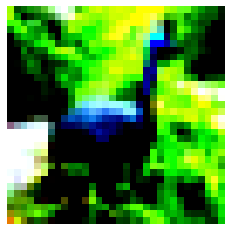

In [10]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.show()

In order to call the model, we need to make the input have the right dimensions. We recall that our model expects $3,072$ features in the input, and that nn works with data organized into batches along the zeroth dimension. So we need to turn our $3 × 32 × 32$ image into a 1D tensor and then add an extra dimension in the zeroth position. 



In [11]:
img_batch = img.view(-1).unsqueeze(0)

# Now we are ready to invoke our model:

out = model(img_batch)
out

tensor([[0.4532, 0.5468]], grad_fn=<SoftmaxBackward0>)

So, we got probabilities! 

In addition, while we know which output probability is supposed to be which (recall our class_names), our network has no indication of that. Is the first entry “airplane” and the second “bird,” or the other way around? The network can’t even tell that at this point. It’s the loss function that associates a meaning with these two numbers, after backpropagation. If the labels are provided as index 0 for “airplane” and index 1 for “bird,” then that’s the order the outputs will be induced to take. Thus, after training, we will be able to get the label as an index by computing the `argmax` of the output probabilities: that is, the index at which we get the maximum probability. 

Conveniently, when supplied with a dimension, `torch.max` returns the maximum element along that dimension as well as the index at which that value occurs. In our case, we need to take the max along the probability vector (not across batches), therefore, dimension 1:

In [12]:
_, index = torch.max(out, dim = 1)
index

tensor([1])

It says the image is a bird. 

---

<h3> <center> <b> <u> A Loss For Classifying </u> </b> </center> </h3>

- Loss is what gives probabilities meaning. 

- Our loss for classification can be computed as follows. For each sample
in the batch:
  1. Run the forward pass, and obtain the output values from the last (linear) layer.
  2. Compute their softmax, and obtain probabilities.
  3. Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because it’s a supervised problem—it’s our ground truth.
  4. Compute its logarithm, slap a minus sign in front of it, and add it to the loss.

- **PyTorch** has an `nn.NLLLoss` class. 
  - However, as opposed to what you might expect, it does not take probabilities but rather takes a tensor of log probabilities as input. 
  - It then computes the NLL of our model given the batch of data. 
  - There’s a good reason behind the input convention: taking the logarithm of a probability is tricky when the probability gets close to zero. The workaround is to use `nn.LogSoftmax` instead of `nn.Softmax`, which takes care to make
the calculation numerically stable.


We can now modify our model to use `nn.LogSoftmax` as the output module:

In [13]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim = 1)
)

# Then we instantiate our NLL loss:

loss = nn.NLLLoss()

The loss takes the output of `nn.LogSoftmax` for a batch as the first argument and a tensor of class indices (zeros and ones, in our case) as the second argument. We can now test it with our birdie:

In [14]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.5285, grad_fn=<NllLossBackward0>)

Ending our investigation of losses, we can look at how using cross-entropy loss
improves over MSE. In the figure below, we see that the cross-entropy loss has some slope when the prediction is off target (in the low-loss corner, the correct class is assigned a predicted probability of 99.97%), while the MSE we dismissed at the beginning saturates much earlier and—crucially—also for very wrong predictions. 

The underlying reason is that the slope of the MSE is too low to compensate for the flatness of the softmax function for wrong predictions. This is why the MSE for probabilities is not a good fit for classification work.

![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic711.png)

---

<h3> <center> <b> <u> Training the Classifier </u> </b> </center> </h3>


Let's train the classifier.

In [15]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim = 1)
)

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 10

for epoch in range(n_epochs):
  for img, label in cifar2:
    out = model(img.view(-1).unsqueeze(0))
    loss = loss_fn(out, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  
  print("Epoch: {} | Loss: {} ".format(epoch, float(loss)))

Epoch: 0 | Loss: 5.091197967529297 
Epoch: 1 | Loss: 7.387642860412598 
Epoch: 2 | Loss: 6.784652233123779 
Epoch: 3 | Loss: 9.931572914123535 
Epoch: 4 | Loss: 5.155850887298584 
Epoch: 5 | Loss: 4.181996822357178 
Epoch: 6 | Loss: 3.1013920307159424 
Epoch: 7 | Loss: 7.673023223876953 
Epoch: 8 | Loss: 5.854520320892334 
Epoch: 9 | Loss: 8.945448875427246 
Epoch: 10 | Loss: 17.048053741455078 
Epoch: 11 | Loss: 5.790252685546875 
Epoch: 12 | Loss: 7.602874279022217 
Epoch: 13 | Loss: 15.614364624023438 
Epoch: 14 | Loss: 4.664062023162842 
Epoch: 15 | Loss: 3.3730580806732178 
Epoch: 16 | Loss: 7.134612083435059 
Epoch: 17 | Loss: 20.795635223388672 
Epoch: 18 | Loss: 10.340953826904297 
Epoch: 19 | Loss: 6.510754108428955 
Epoch: 20 | Loss: 14.100193977355957 
Epoch: 21 | Loss: 2.701233148574829 
Epoch: 22 | Loss: 16.944007873535156 
Epoch: 23 | Loss: 11.111300468444824 
Epoch: 24 | Loss: 6.765738487243652 
Epoch: 25 | Loss: 19.840011596679688 
Epoch: 26 | Loss: 11.464639663696289 


![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic712.png)


- Looking more closely, we made a small change to the training loop. 
  - Evaluating all 10,000 images in a single batch would be too much, so we decided to have an inner loop where we evaluate one sample at a time and backpropagate over that single sample.
  - While in the first case the gradient is accumulated over all samples before being applied, in this case we apply changes to parameters based on a very partial estimation of the gradient on a single sample. 
  - However, what is a good direction for reducing the loss based on one sample might not be a good direction for others. By shuffling samples at each epoch and estimating the gradient on one or (preferably, for stability) a few samples at a time, we are effectively introducing randomness in our gradient descent.
  - Remember SGD? It stands for stochastic gradient descent, and this is what the S is about: working on small batches (aka minibatches) of shuffled data. It turns out that following gradients estimated over minibatches, which are poorer approximations of gradients estimated across the whole dataset, helps convergence and prevents the optimization process from getting stuck in local minima it encounters along the way. 
  
  
  - As depicted in the following figure, gradients from minibatches are randomly off the ideal trajectory, which is part of the reason why we want to use a reasonably small learning rate. 

![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic713.png)


  - Shuffling the dataset at each epoch helps ensure that the sequence of gradients estimated over minibatches is representative of the gradients computed across the full dataset.

- In our training code, we chose minibatches of size 1 by picking one item at a time from the dataset. 
- The `torch.utils.data` module has a class that helps with shuffling and
organizing the data in minibatches: **`DataLoader`**. 
  - The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. 
  - A very common strategy is uniform sampling after shuffling the data at each
epoch. 
  - Following figure shows the data loader shuffling the indices it gets from the `Dataset`.

  ![](https://raw.github.com/ImranNust/DeepLearningWithPyTorch/main/Chapter7/Images/Pic714.png)

  - Let's see how it is done!
    - At a minimum, the `DataLoader` constructor takes a `Dataset` object as input, along with `batch_size` and a `shuffle` Boolean that indicates whether the data needs to be shuffled at the beginning of each epoch:
```
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
shuffle=True)
```
 - A `DataLoader` can be iterated over, so we can use it directly in the inner loop of our new training code:


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 30

for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    outputs = model(imgs.view(imgs.shape[0], -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch: {} | Loss: {}'.format(epoch, float(loss)))

Epoch: 0 | Loss: 0.70762038230896
Epoch: 1 | Loss: 0.33619025349617004
Epoch: 2 | Loss: 0.23642782866954803
Epoch: 3 | Loss: 0.5164990425109863
Epoch: 4 | Loss: 0.3520466983318329
Epoch: 5 | Loss: 0.2545475661754608
Epoch: 6 | Loss: 0.37964802980422974
Epoch: 7 | Loss: 0.44715356826782227
Epoch: 8 | Loss: 0.2303515076637268
Epoch: 9 | Loss: 0.3733629584312439
Epoch: 10 | Loss: 0.24778276681900024
Epoch: 11 | Loss: 0.2415207475423813
Epoch: 12 | Loss: 0.36287447810173035
Epoch: 13 | Loss: 0.2296326458454132
Epoch: 14 | Loss: 0.2518613040447235
Epoch: 15 | Loss: 0.1595701426267624
Epoch: 16 | Loss: 0.37095513939857483
Epoch: 17 | Loss: 0.4326622188091278
Epoch: 18 | Loss: 0.4955534040927887
Epoch: 19 | Loss: 0.34145739674568176
Epoch: 20 | Loss: 0.13626419007778168
Epoch: 21 | Loss: 0.34926268458366394
Epoch: 22 | Loss: 0.17964135110378265
Epoch: 23 | Loss: 0.2869797945022583
Epoch: 24 | Loss: 0.10058492422103882
Epoch: 25 | Loss: 0.6044036149978638
Epoch: 26 | Loss: 0.21336965262889862


---

- At each inner iteration, `imgs` is a tensor of size $64\times 3\times 32\times 32$ -- that is, a minibatch of sixty-four $(32\times 32)$ RGB images -- while `labels` is a tensor of size $64$ containing label indices. 

- We see that the loss decreases somehow, but we have no idea whether it’s low enough. Since our goal here is to correctly assign classes to images, and preferably do that on an independent dataset, we can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

---

In [16]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim = 1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())

print("Accuracy: {}".format(correct / total))


---

- We can improve the accuracy of our model by including a few more layers, like the one shown below:
```
model = nn.Sequential(
  nn.Linear(3072, 1024),
  nn.Tanh(),
  nn.Linear(1024, 512),
  nn.Tanh(),
  nn.Linear(512, 128),
  nn.Tanh(),
  nn.Linear(128, 2),
  nn.LogSoftmax(dim=1))
```

- The combination of `nn.LogSoftmax` and `nn.NLLLoss` is equivalent to using
`nn.CrossEntropyLoss`. 
- This terminology is a particularity of PyTorch, as the `nn.NLLoss` computes, in fact, the cross entropy but with log probability predictions as inputs where `nn.CrossEntropyLoss` takes scores (sometimes called logits).
- Technically, `nn.NLLLoss` is the cross entropy between the Dirac distribution, putting all mass on the target, and the predicted distribution given by the log probability inputs.

- It is quite common to drop the last `nn.LogSoftmax` layer from the network and use `nn.CrossEntropyLoss` as a loss. Let us try that:


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 10

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.302669
Epoch: 1, Loss: 0.460002
Epoch: 2, Loss: 0.729458
Epoch: 3, Loss: 0.460628
Epoch: 4, Loss: 0.482963
Epoch: 5, Loss: 0.798006
Epoch: 6, Loss: 0.311679
Epoch: 7, Loss: 0.413948
Epoch: 8, Loss: 0.386372
Epoch: 9, Loss: 0.606066


---

Let's compute training and validation accuracies

---

In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Training Accuracy: %f" % (correct / total))


correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Validation Accuracy: %f" % (correct / total))

Training Accuracy: 0.816000
Validation Accuracy: 0.778000


---

- PyTorch offers a quick way to determine how many parameters a model has through the `parameters()` method of `nn.Model` (the same method we use to provide the parameters to the optimizer). 
  - To find out how many elements are in each tensor instance, we can call the `numel` method. 
  - Summing those gives us our total count.
- Depending on our use case, counting parameters might require us to check whether a parameter has `requires_grad` set to `True`, as well. 
  - We might want to differentiate the number of trainable parameters from the overall model size. 
- Let’s take a look at what we have right now:


In [18]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
print('Total Learnable Parameters: {}\nParameters of Each Layer: {}'.
      format(sum(numel_list), numel_list))

Total Learnable Parameters: 3737474
Parameters of Each Layer: [3145728, 1024, 524288, 512, 65536, 128, 256, 2]


---

In our model, the first layer `(nn.Linear(3072, 1024)` has $3072$ input features and $1024$ output neurons. We also know that a linear layer computes $y = weight * x + bias$, and if $x$ has length 3,072 (disregarding the batch dimension for simplicity) and $y$ must have length $1,024$, then the weight tensor needs to be of size $1,024 × 3,072$ and the bias size must be $1,024$. And $1,024 * 3,072 + 1,024$ = 3,146,752$. We can verify these quantities directly:

---

In [21]:
linear = nn.Linear(3072, 1024)
print('Weight Shape: {}\nBias Shape: {}'.
      format(linear.weight.shape, linear.bias.shape))

Weight Shape: torch.Size([1024, 3072])
Bias Shape: torch.Size([1024])
